In [7]:
# ======================================================
# 1. Importações
# ======================================================
import os
import numpy as np
import librosa
import soundfile as sf
import scipy.fft
import joblib
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import time

# ======================================================
# 2. Configurações
# ======================================================
DATASET_DIR = ""   # <-- COLOQUE O MESMO DIRETÓRIO USADO NA CNN
REAL_DIR = os.path.join(DATASET_DIR, "real")
FAKE_DIR = os.path.join(DATASET_DIR, "fake")

SVM_MODEL_PATH = "svm_lfcc.pkl"

SAMPLE_RATE = 16000
N_LFCC = 40
N_FFT = 512
HOP = 160
WIN = 400

# ======================================================
# 3. Funções auxiliares
# ======================================================
def load_audio(path):
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if sr != SAMPLE_RATE:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=sr, target_sr=SAMPLE_RATE)
    return wav.astype(np.float32)

def linear_filter_banks(sr, n_fft, n_filters, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr / 2

    freqs = np.linspace(0, sr / 2, 1 + n_fft // 2)
    edges = np.linspace(fmin, fmax, n_filters + 2)
    fbanks = np.zeros((n_filters, len(freqs)))

    for i in range(n_filters):
        left = edges[i]
        center = edges[i + 1]
        right = edges[i + 2]

        left_slope = (freqs - left) / (center - left)
        right_slope = (right - freqs) / (right - center)

        fbanks[i] = np.maximum(0, np.minimum(left_slope, right_slope))

    return fbanks

def extract_lfcc_mean(wav):
    # STFT power
    S = np.abs(librosa.stft(wav, n_fft=N_FFT, hop_length=HOP, win_length=WIN))**2

    fbanks = linear_filter_banks(SAMPLE_RATE, N_FFT, N_LFCC)
    filtered = np.dot(fbanks, S)

    logS = np.log(filtered + 1e-10)

    lfcc = scipy.fft.dct(logS, axis=0, norm="ortho")
    return np.mean(lfcc, axis=1)

def count_audio_files(root):
    total = 0
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".wav", ".flac", ".mp3")):
                total += 1
    return total

# ======================================================
# 4. Carregar dataset igual ao usado na CNN
# ======================================================
def load_dataset_lfcc(real_dir, fake_dir):

    total_real = count_audio_files(real_dir)
    total_fake = count_audio_files(fake_dir)
    total_files = total_real + total_fake
    print(f"Total: {total_files} (Real={total_real}, Fake={total_fake})")

    X, y, persons = [], [], []
    loaded = 0

    for label_dir, label in [(real_dir, 0), (fake_dir, 1)]:
        for person in os.listdir(label_dir):
            p_dir = os.path.join(label_dir, person)
            if os.path.isdir(p_dir):
                for root, _, files in os.walk(p_dir):
                    for f in files:
                        if f.lower().endswith((".wav",".flac",".mp3")):
                            path = os.path.join(root,f)
                            wav = load_audio(path)
                            feat = extract_lfcc_mean(wav)

                            X.append(feat)
                            y.append(label)
                            persons.append(person)

                            loaded += 1
                            perc = (loaded/total_files)*100
                            print(f"\rExtraindo LFCC... {perc:.2f}% ({loaded}/{total_files})", end="")

    print("\n")
    return np.array(X), np.array(y), np.array(persons)

# ======================================================
# 5. Carregar dataset
# ======================================================
print("Carregando dataset para SVM...")
start = time.time()
X, y, persons = load_dataset_lfcc(REAL_DIR, FAKE_DIR)
print(f"Concluído em {time.time()-start:.2f}s")

# ======================================================
# 6. Divisão de teste igual à CNN
# ======================================================
from sklearn.model_selection import train_test_split

unique_persons = np.unique(persons)
_, test_persons = train_test_split(unique_persons, test_size=0.2, random_state=42)

test_mask = np.isin(persons, test_persons)
X_test = X[test_mask]
y_test = y[test_mask]

print("Teste:", X_test.shape, y_test.shape)

# ======================================================
# 7. Carregar e avaliar o SVM
# ======================================================
print("Carregando modelo SVM...")
svm = joblib.load(SVM_MODEL_PATH)
print("Modelo carregado!")

y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

print("\n====== CLASSIFICATION REPORT (SVM) ======")
print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))


Carregando dataset para SVM...
Total: 36975 (Real=19999, Fake=16976)
Extraindo LFCC... 100.00% (36975/36975)

Concluído em 347.47s
Teste: (7182, 40) (7182,)
Carregando modelo SVM...
Modelo carregado!


/Users/moniquecavalcanti/Documents/POLI/TCC/venv/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



====== CLASSIFICATION REPORT (SVM) ======
              precision    recall  f1-score   support

        Real       0.89      0.98      0.93      4000
        Fake       0.97      0.85      0.91      3182

    accuracy                           0.92      7182
   macro avg       0.93      0.91      0.92      7182
weighted avg       0.93      0.92      0.92      7182

Accuracy: 0.9216095795043163

Matriz de confusão:
[[3918   82]
 [ 481 2701]]


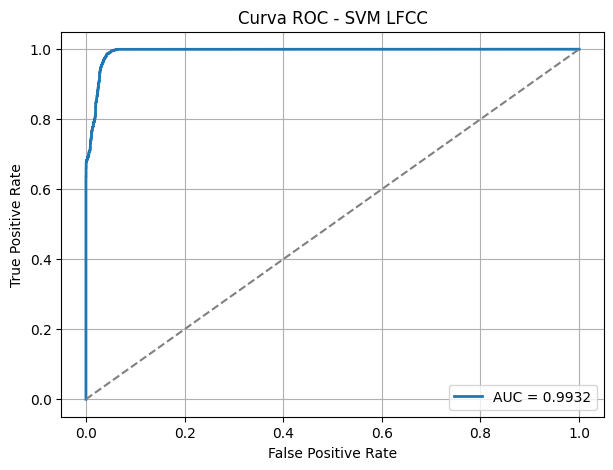

AUC (Área sob a Curva ROC): 0.9932


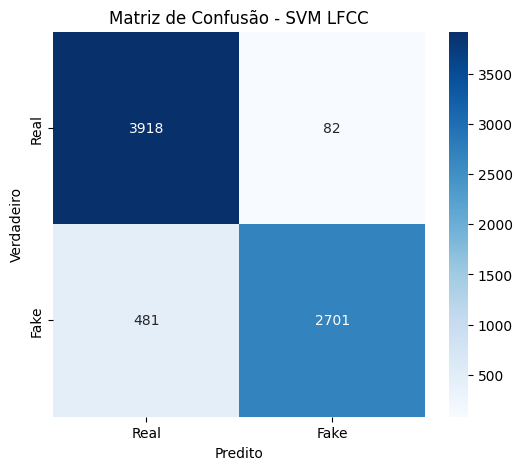

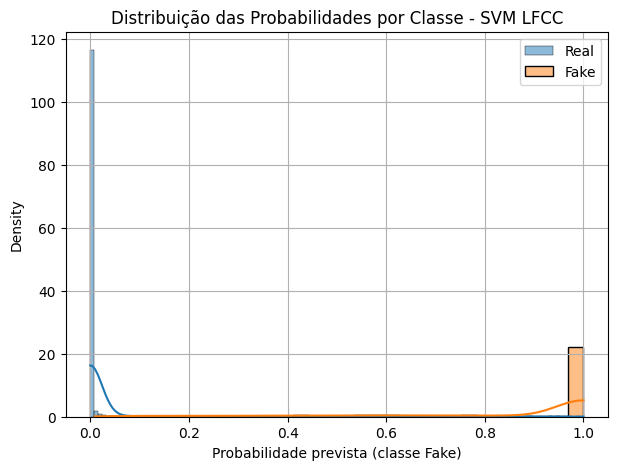

===== MÉTRICAS COMPLEMENTARES =====
Precisão (Precision): 0.9705
Recall (Sensibilidade): 0.8488
F1-Score: 0.9056
MAE das Probabilidades: 0.0805

===== DESEMPENHO DO MODELO SVM =====
Tempo médio por amostra: 0.238 ms
Amostras por segundo (FPS): 4203.61


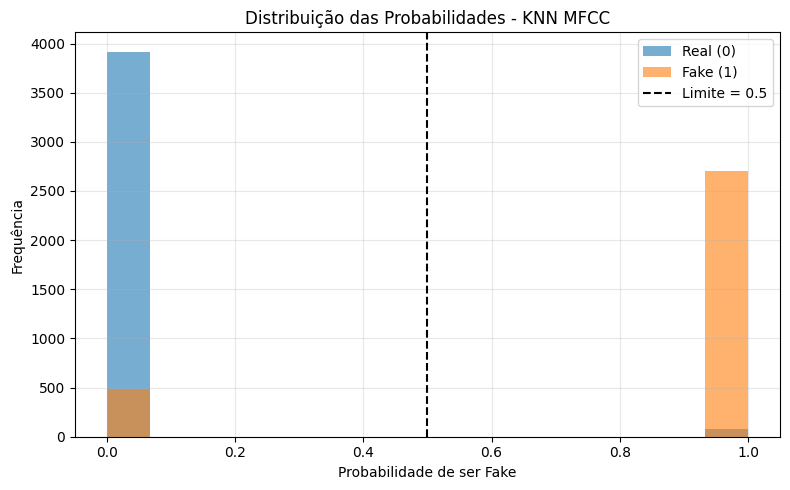

In [8]:
# =====================================================
# 9. Relatórios Avançados e Gráficos para o TCC (SVM)
# =====================================================
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, mean_absolute_error
import numpy as np
import time

# =====================================================
# 1. Curva ROC
# =====================================================
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM LFCC")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC (Área sob a Curva ROC): {roc_auc:.4f}")


# =====================================================
# 2. Matriz de Confusão
# =====================================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Matriz de Confusão - SVM LFCC")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


# =====================================================
# 3. Distribuição das Probabilidades
# =====================================================
plt.figure(figsize=(7, 5))
sns.histplot(y_score[y_test == 0], label="Real", kde=True, stat="density")
sns.histplot(y_score[y_test == 1], label="Fake", kde=True, stat="density")
plt.title("Distribuição das Probabilidades por Classe - SVM LFCC")
plt.xlabel("Probabilidade prevista (classe Fake)")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# 4. Métricas complementares
# =====================================================
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
mae       = mean_absolute_error(y_test, y_score)

print("===== MÉTRICAS COMPLEMENTARES =====")
print(f"Precisão (Precision): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MAE das Probabilidades: {mae:.4f}")


# =====================================================
# 5. Tempo de inferência do SVM
# =====================================================
start = time.time()
_ = svm.predict(X_test)
end = time.time()

avg_time = (end - start) / len(X_test)
fps = 1 / avg_time

print("\n===== DESEMPENHO DO MODELO SVM =====")
print(f"Tempo médio por amostra: {avg_time*1000:.3f} ms")
print(f"Amostras por segundo (FPS): {fps:.2f}")


# =====================================================
# 6. Comparação Verdadeiro vs Predito
# =====================================================
plt.figure(figsize=(8,5))
plt.hist(y_pred[y_test == 0], bins=15, alpha=0.6, label="Real (0)")
plt.hist(y_pred[y_test == 1], bins=15, alpha=0.6, label="Fake (1)")
plt.axvline(0.5, color="k", linestyle="--", label="Limite = 0.5")

plt.title("Distribuição das Probabilidades - KNN MFCC")
plt.xlabel("Probabilidade de ser Fake")
plt.ylabel("Frequência")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()